# Ziad Al-Ziadi (150010258) - INM460 Computer Vision (2020/21)
### Module leader: Giacomo Tarroni

# Facial Emotion Recognition with CNN (Convolutional Neural Network )

In the preceding section, we will implement several CNN on the Facial Emotion Recognition (FER) . It will include a manually defined CNN and several pre-trained CNNs. The models will be trained on the Real-world Affective Faces (RAF) dataset consisting of facial images that depcit emotions that are labeled as:

1: Surprise
2: Fear
3: Disgust
4: Happiness
5: Sadness
6: Anger
7: Neutral

Ultimately, the objective is to have the CNN accurately predict the emotions in unseen images.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import os
from PIL import Image
import torch.optim as optim
from torch.optim import lr_scheduler
import cv2
from google.colab.patches import cv2_imshow

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)

cuda:1


In [ ]:
!pip install opencv-python==4.4.0.46

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
zip_path = "/content/drive/MyDrive/CV_Submission/CW_Dataset.zip"
!cp "{zip_path}" .
!yes|unzip -q CW_Dataset.zip

In [ ]:
# Defing our custom Dataset class to read in our image

class GetDataLabel(Dataset):

  def __init__(self, df, root, transform = None):
    self.df = df
    self.root = root
    self.transform = transform

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()

    img_path = os.path.join(self.root, self.df.iloc[idx, 0])
    img = Image.open(img_path)
    label = self.df.iloc[idx, 1]

    if self.transform:
      img = self.transform(img)
    
    # img_lab = {"image": img,
    #            "label": label}
    return img, label
  

In [ ]:
# Creating the test and trian path

train_txt = "/content/labels/list_label_train.txt"
test_txt = "/content/labels/list_label_test.txt"

colnames = ["Image_id", "Label"]
train_lab = pd.read_csv(train_txt, names = colnames, header = None, delim_whitespace = True)
test_lab = pd.read_csv(test_txt, names = colnames, header = None, delim_whitespace = True)

# Here, I'm cleaning the label string to isolate the label value

train_lab["Image_id"] = train_lab["Image_id"].apply(lambda i: i[:-4])
test_lab["Image_id"] = test_lab["Image_id"].apply(lambda i: i[:-4])

# I append the string "_aligned.jpg" so that it matches our image names

train_lab["Image_id"] = train_lab["Image_id"] + "_aligned.jpg"
test_lab["Image_id"] = test_lab["Image_id"] + "_aligned.jpg"

# Here, I carry out a little bit of renidexing: note I have to +1 after to maintain correct label value

train_lab["Label"] = train_lab["Label"].apply(lambda i: i - 1)

test_lab["Label"] = test_lab["Label"].apply(lambda i: i - 1)

In [ ]:
# Our torcg transformer which will be applied to our image data

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [ ]:
# Creating our train and test images and applying them to our DataLoader
train_image_path = "/content/train"
test_image_path = "/content/test"

train_img = GetDataLabel(df = train_lab, root = train_image_path, transform = transform)

test_img = GetDataLabel(df = test_lab,root = test_image_path, transform = transform)

trainloader = torch.utils.data.DataLoader(train_img, batch_size=64,
                                          shuffle=True, num_workers=2)


testloader = torch.utils.data.DataLoader(test_img, batch_size=64,
                                         shuffle=False, num_workers=2)

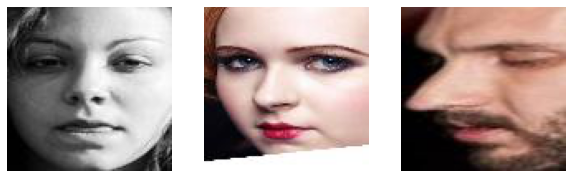

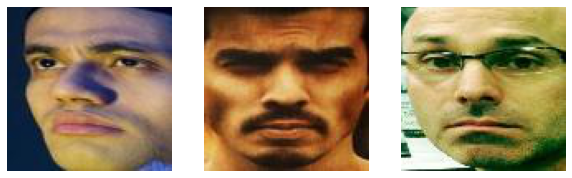

In [ ]:
# Visualising our images

train_1 = Image.open(train_image_path + "/train_12271_aligned.jpg")
train_2 = Image.open(train_image_path + "/train_12266_aligned.jpg")
train_3 = Image.open(train_image_path + "/train_12255_aligned.jpg")

test_1 = Image.open(test_image_path + "/test_3053_aligned.jpg")
test_2 = Image.open(test_image_path + "/test_3038_aligned.jpg")
test_3 = Image.open(test_image_path + "/test_3028_aligned.jpg")


fig, ax = plt.subplots(1, 3, figsize=(10 ,7))
ax[0].imshow(train_1)
ax[0].set_axis_off()

ax[1].imshow(train_2)
ax[1].set_axis_off()

ax[2].imshow(train_3)
ax[2].set_axis_off()

fig, ax = plt.subplots(1, 3, figsize=(10 ,7))
ax[0].imshow(test_1)
ax[0].set_axis_off()

ax[1].imshow(test_2)
ax[1].set_axis_off()

ax[2].imshow(test_3)
ax[2].set_axis_off()

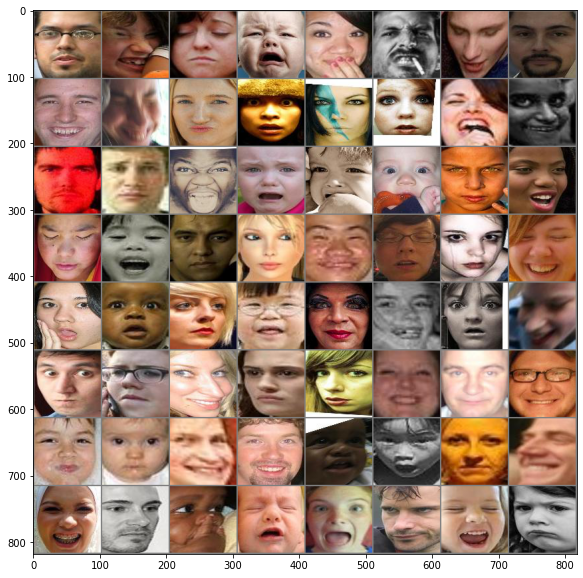

In [ ]:
# Plotting an image grid to get a better understanding of our image variety

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, lab = dataiter.next()
fig = plt.subplots(1, 1, figsize=(10 ,10))
imshow(torchvision.utils.make_grid(images))

In [ ]:
# Here, we define a "vanila" PyTorch CNN in order to compare with other pre-trained models
#https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 22 * 22 , 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 8)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), 16 * 22 *22)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
# Initating our CNN as well as our optimisation and loss function

net = Net()
criterion = nn.CrossEntropyLoss().cuda()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
# In this loop, we will train and test our "vanilla" CNN and evaluate it's accuracy

count = 0
cnn_loss_list = []
iteration_list = []
cnn_accuracy_list = []
epochs = 30

for epoch in range(epochs):
    for i, (images, labels) in enumerate(trainloader):
            net = net.cuda()

            optimizer.zero_grad()
            outputs = net(images.cuda())
            cnn_loss = criterion(outputs.cuda(), labels.cuda())
            cnn_loss.backward()
            optimizer.step()

            count += 1

            if count % 50 == 0:
                correct = 0
                total = 0

                for i, (images, labels) in enumerate(testloader):

                    outputs = net(images.cuda())
                    predicted = torch.max(outputs.data, 1)[1]
                    total += len(labels)
                    correct += (predicted == labels.cuda()).sum()
                cnn_accuracy = 100 * correct / float(total)

                cnn_loss_list.append(cnn_loss.data)
                iteration_list.append(count)
                cnn_accuracy_list.append(cnn_accuracy)

                if count % 500 == 0:
                    print("Iteration: {} - Loss: {} - CNN Accuracy: {} %".format(count, cnn_loss.data, cnn_accuracy))

Iteration: 500 - Loss: 1.3630237579345703 - CNN Accuracy: 48.66362380981445 %
Iteration: 1000 - Loss: 0.989952027797699 - CNN Accuracy: 62.15775680541992 %
Iteration: 1500 - Loss: 0.716688871383667 - CNN Accuracy: 65.22164154052734 %
Iteration: 2000 - Loss: 0.6766716837882996 - CNN Accuracy: 67.89439392089844 %
Iteration: 2500 - Loss: 0.5649760961532593 - CNN Accuracy: 69.88265991210938 %
Iteration: 3000 - Loss: 0.7087396383285522 - CNN Accuracy: 70.4693603515625 %
Iteration: 3500 - Loss: 0.5338958501815796 - CNN Accuracy: 71.80573272705078 %
Iteration: 4000 - Loss: 0.5696226954460144 - CNN Accuracy: 71.34941101074219 %
Iteration: 4500 - Loss: 0.23566584289073944 - CNN Accuracy: 71.08865356445312 %
Iteration: 5000 - Loss: 0.32536306977272034 - CNN Accuracy: 72.3924331665039 %
Iteration: 5500 - Loss: 0.20050981640815735 - CNN Accuracy: 69.88265991210938 %


In [ ]:
# AlexNet 

# Initating our AlexNet as well as our optimisation and loss function

alexnet_cnn = models.alexnet(pretrained = True)
criterion = nn.CrossEntropyLoss().cuda()
optimizer_ft = optim.SGD(alexnet_cnn.parameters(), lr=0.001, momentum=0.9)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


In [ ]:
# AlexNet

# In this loop, we will train and test our AlexNet and evaluate it's accuracy

count = 0
alexnet_loss_list = []
iteration_list = []
alexnet_accuracy_list = []
epochs = 30

for epoch in range(epochs):
    for i, (images, labels) in enumerate(trainloader):
            alexnet_cnn = alexnet_cnn.cuda()

            optimizer_ft.zero_grad()
            outputs = alexnet_cnn(images.cuda())
            alexnet_loss = criterion(outputs.cuda(), labels.cuda())
            alexnet_loss.backward()
            optimizer_ft.step()

            count += 1

            if count % 50 == 0:
                correct = 0
                total = 0

                for i, (images, labels) in enumerate(testloader):

                    outputs = alexnet_cnn(images.cuda())
                    predicted = torch.max(outputs.data, 1)[1]
                    total += len(labels)
                    correct += (predicted == labels.cuda()).sum()
                alexnet_accuracy = 100 * correct / float(total)

                alexnet_loss_list.append(alexnet_loss.data)
                iteration_list.append(count)
                alexnet_accuracy_list.append(alexnet_accuracy)

                if count % 500 == 0:
                    print("Iteration: {} Loss: {} AlexNet Accuracy: {} %".format(count, alexnet_loss.data, alexnet_accuracy))

Iteration: 500 Loss: 0.8020319938659668 AlexNet Accuracy: 65.4498062133789 %
Iteration: 1000 Loss: 0.5615419149398804 AlexNet Accuracy: 69.49152374267578 %
Iteration: 1500 Loss: 0.898658275604248 AlexNet Accuracy: 71.70795440673828 %
Iteration: 2000 Loss: 0.501828670501709 AlexNet Accuracy: 72.7835693359375 %
Iteration: 2500 Loss: 0.48096734285354614 AlexNet Accuracy: 74.31551361083984 %
Iteration: 3000 Loss: 0.282065749168396 AlexNet Accuracy: 72.91394805908203 %
Iteration: 3500 Loss: 0.39730626344680786 AlexNet Accuracy: 75.55410766601562 %
Iteration: 4000 Loss: 0.09618008136749268 AlexNet Accuracy: 74.73924255371094 %
Iteration: 4500 Loss: 0.027867242693901062 AlexNet Accuracy: 75.71707916259766 %
Iteration: 5000 Loss: 0.04311374947428703 AlexNet Accuracy: 74.6088638305664 %
Iteration: 5500 Loss: 0.04895635321736336 AlexNet Accuracy: 73.30508422851562 %


In [ ]:
# VGG16

# Initating our VGG16 as well as our optimisation and loss function

vgg16_cnn = models.vgg16(pretrained = True)
criterion = nn.CrossEntropyLoss().cuda()
optimizer_ft = optim.SGD(vgg16_cnn.parameters(), lr=0.001, momentum=0.9)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


In [ ]:
# VGG16

# In this loop, we will train and test our VGG16 and evaluate it's accuracy


count = 0
vgg_loss_list = []
iteration_list = []
vgg_accuracy_list = []
epochs = 30

for epoch in range(epochs):
    for i, (images, labels) in enumerate(trainloader):
            vgg16_cnn = vgg16_cnn.cuda()

            optimizer_ft.zero_grad()
            outputs = vgg16_cnn(images.cuda())
            vgg_loss = criterion(outputs.cuda(), labels.cuda())
            vgg_loss.backward()
            optimizer_ft.step()

            count += 1

            if count % 50 == 0:
                correct = 0
                total = 0

                for i, (images, labels) in enumerate(testloader):

                    outputs = vgg16_cnn(images.cuda())
                    predicted = torch.max(outputs.data, 1)[1]
                    total += len(labels)
                    correct += (predicted == labels.cuda()).sum()
                vgg_accuracy = 100 * correct / float(total)

                vgg_loss_list.append(vgg_loss.data)
                iteration_list.append(count)
                vgg_accuracy_list.append(vgg_accuracy)

                if count % 500 == 0:
                    print("Iteration: {} Loss: {} VGG16 Accuracy: {} %".format(count, vgg_loss.data, vgg_accuracy))

Iteration: 500 Loss: 0.8090625405311584 VGG16 Accuracy: 71.57757568359375 %
Iteration: 1000 Loss: 0.4498851001262665 VGG16 Accuracy: 73.79399871826172 %
Iteration: 1500 Loss: 0.34358537197113037 VGG16 Accuracy: 78.25945281982422 %
Iteration: 2000 Loss: 0.06511251628398895 VGG16 Accuracy: 77.3468017578125 %
Iteration: 2500 Loss: 0.05882301926612854 VGG16 Accuracy: 78.97653198242188 %
Iteration: 3000 Loss: 0.048937492072582245 VGG16 Accuracy: 78.35723114013672 %
Iteration: 3500 Loss: 0.04977748915553093 VGG16 Accuracy: 78.16166687011719 %
Iteration: 4000 Loss: 0.0005761461216025054 VGG16 Accuracy: 80.76922607421875 %
Iteration: 4500 Loss: 0.0004417883465066552 VGG16 Accuracy: 80.86701202392578 %
Iteration: 5000 Loss: 6.624926754739136e-05 VGG16 Accuracy: 81.02998352050781 %
Iteration: 5500 Loss: 0.00017998256953433156 VGG16 Accuracy: 81.09517669677734 %


In [ ]:
# GoogLeNet

# Initating our GoogLeNet as well as our optimisation and loss function

googlenet_cnn = models.googlenet(pretrained = True)
num_ftrs_googlenet = googlenet_cnn.fc.in_features
googlenet_cnn.fc = nn.Linear(num_ftrs_googlenet, 8)
googlenet_cnn = googlenet_cnn

criterion = nn.CrossEntropyLoss().cuda()
optimizer_ft = optim.SGD(googlenet_cnn.parameters(), lr=0.001, momentum=0.9)

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


In [ ]:
# GoogLeNet

# In this loop, we will train and test our GoogLeNet and evaluate it's accuracy

count = 0
googlenet_loss_list = []
iteration_list = []
googlenet_accuracy_list = []
epochs = 30

for epoch in range(epochs):
    for i, (images, labels) in enumerate(trainloader):
            googlenet_cnn = googlenet_cnn.cuda()

            optimizer_ft.zero_grad()
            outputs = googlenet_cnn(images.cuda())
            googlenet_loss = criterion(outputs.cuda(), labels.cuda())
            googlenet_loss.backward()
            optimizer_ft.step()

            count += 1

            if count % 50 == 0:
                correct = 0
                total = 0

                for i, (images, labels) in enumerate(testloader):

                    outputs = googlenet_cnn(images.cuda())
                    predicted = torch.max(outputs.data, 1)[1]
                    total += len(labels)
                    correct += (predicted == labels.cuda()).sum()
                googlenet_accuracy = 100 * correct / float(total)

                googlenet_loss_list.append(googlenet_loss.data)
                iteration_list.append(count)
                googlenet_accuracy_list.append(googlenet_accuracy)

                if count % 500 == 0:
                    print("Iteration: {} Loss: {} GoogLeNet Accuracy: {} %".format(count, googlenet_loss.data, googlenet_accuracy))

Iteration: 500 Loss: 0.8025007843971252 GoogLeNet Accuracy: 48.337677001953125 %
Iteration: 1000 Loss: 0.5673249959945679 GoogLeNet Accuracy: 51.30377960205078 %
Iteration: 1500 Loss: 0.24103900790214539 GoogLeNet Accuracy: 52.0860481262207 %
Iteration: 2000 Loss: 0.0641835629940033 GoogLeNet Accuracy: 52.90091323852539 %
Iteration: 2500 Loss: 0.04498858377337456 GoogLeNet Accuracy: 52.57496643066406 %
Iteration: 3000 Loss: 0.01907976344227791 GoogLeNet Accuracy: 53.29204559326172 %
Iteration: 3500 Loss: 0.008953957818448544 GoogLeNet Accuracy: 52.966102600097656 %
Iteration: 4000 Loss: 0.02314218319952488 GoogLeNet Accuracy: 52.868316650390625 %
Iteration: 4500 Loss: 0.01335972547531128 GoogLeNet Accuracy: 53.324642181396484 %
Iteration: 5000 Loss: 0.0051765176467597485 GoogLeNet Accuracy: 53.29204559326172 %
Iteration: 5500 Loss: 0.0038329113740473986 GoogLeNet Accuracy: 53.520206451416016 %


In [ ]:
# ResNeXt

resnet_xt = resnext50_32x4d = models.resnext50_32x4d(pretrained=True)
num_ftrs_resnet_xt = resnet_xt.fc.in_features
resnet_xt.fc = nn.Linear(num_ftrs_resnet_xt, 8)
resnet_xt = resnet_xt

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth


In [ ]:
# ResNetXt

count = 0
resnet_loss_list = []
iteration_list = []
resnet_accuracy_list = []
epochs = 30

for epoch in range(epochs):
    for i, (images, labels) in enumerate(trainloader):
            resnet_xt = resnet_xt.cuda()

            optimizer_ft.zero_grad()
            outputs = resnet_xt(images.cuda())
            resnet_loss = criterion(outputs.cuda(), labels.cuda())
            resnet_loss.backward()
            optimizer_ft.step()

            count += 1

            if count % 50 == 0:
                correct = 0
                total = 0

                for i, (images, labels) in enumerate(testloader):

                    outputs = resnet_xt(images.cuda())
                    predicted = torch.max(outputs.data, 1)[1]
                    total += len(labels)
                    correct += (predicted == labels.cuda()).sum()
                resnet_accuracy = 100 * correct / float(total)

                resnet_loss_list.append(resnet_loss.data)
                iteration_list.append(count)
                resnet_accuracy_list.append(resnet_accuracy)

                if count % 500 == 0:
                    print("Iteration: {} Loss: {} ResNetXt Accuracy: {} %".format(count, resnet_loss.data, resnet_accuracy))

Iteration: 500 Loss: 2.315615653991699 ResNetXt Accuracy: 7.496740341186523 %
Iteration: 1000 Loss: 2.268488883972168 ResNetXt Accuracy: 7.496740341186523 %
Iteration: 1500 Loss: 2.226287841796875 ResNetXt Accuracy: 7.496740341186523 %
Iteration: 2000 Loss: 2.3241682052612305 ResNetXt Accuracy: 7.496740341186523 %
Iteration: 2500 Loss: 2.2641263008117676 ResNetXt Accuracy: 7.496740341186523 %
Iteration: 3000 Loss: 2.324420690536499 ResNetXt Accuracy: 7.496740341186523 %
Iteration: 3500 Loss: 2.303459882736206 ResNetXt Accuracy: 7.496740341186523 %
Iteration: 4000 Loss: 2.2275230884552 ResNetXt Accuracy: 7.496740341186523 %
Iteration: 4500 Loss: 2.2866194248199463 ResNetXt Accuracy: 7.496740341186523 %
Iteration: 5000 Loss: 2.246884822845459 ResNetXt Accuracy: 7.496740341186523 %
Iteration: 5500 Loss: 2.274750232696533 ResNetXt Accuracy: 7.496740341186523 %


After training five different CNN models, we can conclude that the pre-trained VGG16 model proved to be the most accurate and had the lowest loss score. The worst performing CNN was ourthe ResNetXt model. Therefore, we will use the VGG16 model on the *video in the wild* challenge. The VGG16 model will be saved as a pickle file.

In [ ]:
import pickle

with open("vgg_cnn.pkl", "wb") as vgg_cnn:
    pickle.dump(vgg16_cnn, vgg_cnn)